<a href="https://colab.research.google.com/github/hima111997/English-hand-written-recognition/blob/master/english_handwritten_V_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir /root/.kaggle
!mkdir /content/.kaggle
import json
token = {'username':'ibrahimohamed','key':'84672b6ed3b33745eeb4e082de80350d'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
 
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json    
!ls  /root/.kaggle
!kaggle config set -n path -v/content

kaggle.json
- path is now set to: /content


In [3]:
# The Data set contains all the English alphabets (small and caps), digits (0-9) and some special characters ( @, #, $, & )
!kaggle datasets download -d vaibhao/handwritten-characters

 99% 1.61G/1.62G [00:15<00:00, 158MB/s]
100% 1.62G/1.62G [00:15<00:00, 113MB/s]


In [4]:
import zipfile, os
with zipfile.ZipFile('/content/datasets/vaibhao/handwritten-characters/handwritten-characters.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/hand_written')

# New Model

In [ ]:
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform
import datetime
%load_ext tensorboard

inputs = Input(shape = (32,32,3))

X = layers.Conv2D(64, (7,7), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(inputs) #32
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 15

X = layers.Conv2D(128, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 15
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) #7

X = layers.Conv2D(256, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 7
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (1,1))(X) # 3

X = layers.Conv2D(512, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 7
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 3

X = layers.GlobalAveragePooling2D()(X) # 256

X = layers.Dense(600, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(500, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(200, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(75, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(39, activation = 'softmax')(X)



log_dir = "/content/drive/My Drive/Colab Notebooks/english_recognition/fit/english_written" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = inputs, outputs = X)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 128)       512   

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255., 
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3],
                               width_shift_range = .5,
                               height_shift_range = .25,
                               shear_range = .3,
                               fill_mode = 'constant',
                               cval = 0,
                               validation_split = .2
                               )

valid_gen = ImageDataGenerator(rescale = 1/255., 
                               validation_split = .2)

train_generator = train_gen.flow_from_directory('/content/hand_written/Train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='training')

valid_generator = valid_gen.flow_from_directory('/content/hand_written/Train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='validation')

Using TensorFlow backend.


Found 667244 images belonging to 39 classes.
Found 166792 images belonging to 39 classes.


In [ ]:
steps_per_epoch = int(667244/32)
validation_steps = int(166792/32)

print(steps_per_epoch)
validation_steps

20851


5212

In [ ]:
optim = optimizers.SGD(lr = .01, momentum=.09)
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy', # classes as integers
              metrics=['accuracy',
                       Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

In [ ]:
model.fit(train_generator,
          epochs = 10,
          validation_data = valid_generator,
          steps_per_epoch = steps_per_epoch,
          validation_steps = validation_steps,
          callbacks=[tensorboard_callback],
          verbose = 2)
# loss: 0.5857 - accuracy: 0.8473   val_loss: 0.3993 - val_accuracy: 0.9009 at epoch 20

Epoch 1/10
20851/20851 - 669s - loss: 0.4167 - accuracy: 0.8884 - recall: 0.8548 - precision: 0.9241 - auc: 0.9923 - auc_1: 0.9461 - val_loss: 0.2767 - val_accuracy: 0.9267 - val_recall: 0.9222 - val_precision: 0.9355 - val_auc: 0.9931 - val_auc_1: 0.9689
Epoch 2/10
20851/20851 - 699s - loss: 0.4122 - accuracy: 0.8894 - recall: 0.8563 - precision: 0.9247 - auc: 0.9924 - auc_1: 0.9471 - val_loss: 0.3268 - val_accuracy: 0.9217 - val_recall: 0.9171 - val_precision: 0.9312 - val_auc: 0.9910 - val_auc_1: 0.9612
Epoch 3/10
20851/20851 - 710s - loss: 0.4085 - accuracy: 0.8907 - recall: 0.8578 - precision: 0.9259 - auc: 0.9924 - auc_1: 0.9477 - val_loss: 0.2537 - val_accuracy: 0.9300 - val_recall: 0.9245 - val_precision: 0.9402 - val_auc: 0.9946 - val_auc_1: 0.9738
Epoch 4/10
20851/20851 - 705s - loss: 0.4057 - accuracy: 0.8908 - recall: 0.8578 - precision: 0.9258 - auc: 0.9925 - auc_1: 0.9482 - val_loss: 0.2667 - val_accuracy: 0.9302 - val_recall: 0.9253 - val_precision: 0.9388 - val_auc: 0.9

In [ ]:
model.save('english_handwritten_1layer_addedV3')
!zip -r /content/english_handwritten_1layer_addedV3.zip /content/english_handwritten_1layer_addedV3
from google.colab import files
files.download("/content/english_handwritten_1layer_addedV3.zip")

INFO:tensorflow:Assets written to: english_handwritten_1layer_addedV3/assets
  adding: content/english_handwritten_1layer_addedV3/ (stored 0%)
  adding: content/english_handwritten_1layer_addedV3/variables/ (stored 0%)
  adding: content/english_handwritten_1layer_addedV3/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: content/english_handwritten_1layer_addedV3/variables/variables.data-00001-of-00002 (deflated 9%)
  adding: content/english_handwritten_1layer_addedV3/variables/variables.index (deflated 74%)
  adding: content/english_handwritten_1layer_addedV3/assets/ (stored 0%)
  adding: content/english_handwritten_1layer_addedV3/saved_model.pb (deflated 90%)


# continue training


In [5]:
with zipfile.ZipFile('/content/english_handwritten_1layer_addedV6.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/english_handwritten_1layer_addedV6')    

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras import optimizers

model = load_model('/content/english_handwritten_1layer_addedV6/content/english_handwritten_1layer_addedV6')
optim = optimizers.SGD(lr = .01, momentum=.09)
model.compile(optimizer = optim,
              loss = 'categorical_crossentropy', # classes as integers
              metrics=['accuracy',
                       Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

In [7]:
log_dir = "/content/drive/My Drive/Colab Notebooks/english_recognition/fit/english_written20200616-134728"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255., 
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3],
                               width_shift_range = .5,
                               height_shift_range = .25,
                               shear_range = .3,
                               fill_mode = 'constant',
                               cval = 0,
                               validation_split = .2
                               )

valid_gen = ImageDataGenerator(rescale = 1/255., 
                               validation_split = .2)

train_generator = train_gen.flow_from_directory('/content/hand_written/Train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='training')

valid_generator = valid_gen.flow_from_directory('/content/hand_written/Train',
                                                 target_size=(32, 32),
                                                 batch_size=32,
                                                 class_mode = 'categorical',
                                                 seed=42,
                                                 subset='validation')
steps_per_epoch = int(667244/32)
validation_steps = int(166792/32)

Using TensorFlow backend.


Found 667244 images belonging to 39 classes.
Found 166792 images belonging to 39 classes.


In [9]:
model.fit(train_generator,
          epochs = 10,
          validation_data = valid_generator,
          steps_per_epoch = steps_per_epoch,
          validation_steps = validation_steps,
          callbacks=[tensorboard_callback],
          verbose = 2) # loss: 0.3547 - accuracy: 0.9014 - val_loss: 0.2154 - val_accuracy: 0.9381 at epoch 50

Epoch 1/10
20851/20851 - 1838s - loss: 0.3418 - accuracy: 0.9043 - recall: 0.8780 - precision: 0.9333 - auc: 0.9941 - auc_1: 0.9599 - val_loss: 0.1952 - val_accuracy: 0.9412 - val_recall: 0.9378 - val_precision: 0.9469 - val_auc: 0.9966 - val_auc_1: 0.9819
Epoch 2/10
20851/20851 - 1349s - loss: 0.3428 - accuracy: 0.9040 - recall: 0.8774 - precision: 0.9330 - auc: 0.9941 - auc_1: 0.9598 - val_loss: 0.1891 - val_accuracy: 0.9428 - val_recall: 0.9389 - val_precision: 0.9500 - val_auc: 0.9967 - val_auc_1: 0.9830
Epoch 3/10
20851/20851 - 1177s - loss: 0.3398 - accuracy: 0.9045 - recall: 0.8780 - precision: 0.9335 - auc: 0.9942 - auc_1: 0.9602 - val_loss: 0.2136 - val_accuracy: 0.9395 - val_recall: 0.9340 - val_precision: 0.9500 - val_auc: 0.9957 - val_auc_1: 0.9786
Epoch 4/10
20851/20851 - 1178s - loss: 0.3400 - accuracy: 0.9046 - recall: 0.8781 - precision: 0.9337 - auc: 0.9942 - auc_1: 0.9603 - val_loss: 0.2041 - val_accuracy: 0.9387 - val_recall: 0.9317 - val_precision: 0.9512 - val_auc:

In [11]:
#model.save('english_handwritten_1layer_addedV7')
#!zip -r /content/english_handwritten_1layer_addedV7.zip /content/english_handwritten_1layer_addedV7
from google.colab import files
files.download("/content/english_handwritten_1layer_addedV7.zip")

In [12]:
test_gen = ImageDataGenerator(rescale = 1/255.)

test_generator = test_gen.flow_from_directory('/content/hand_written/Validation',
                                                 target_size=(32, 32),
                                                 batch_size=1,
                                                  shuffle=False,
                                                 class_mode = 'categorical'
                                                 )


Found 22524 images belonging to 39 classes.


In [14]:
test_generator.class_indices

{'#': 0,
 '$': 1,
 '&': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '@': 13,
 'A': 14,
 'B': 15,
 'C': 16,
 'D': 17,
 'E': 18,
 'F': 19,
 'G': 20,
 'H': 21,
 'I': 22,
 'J': 23,
 'K': 24,
 'L': 25,
 'M': 26,
 'N': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38}

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


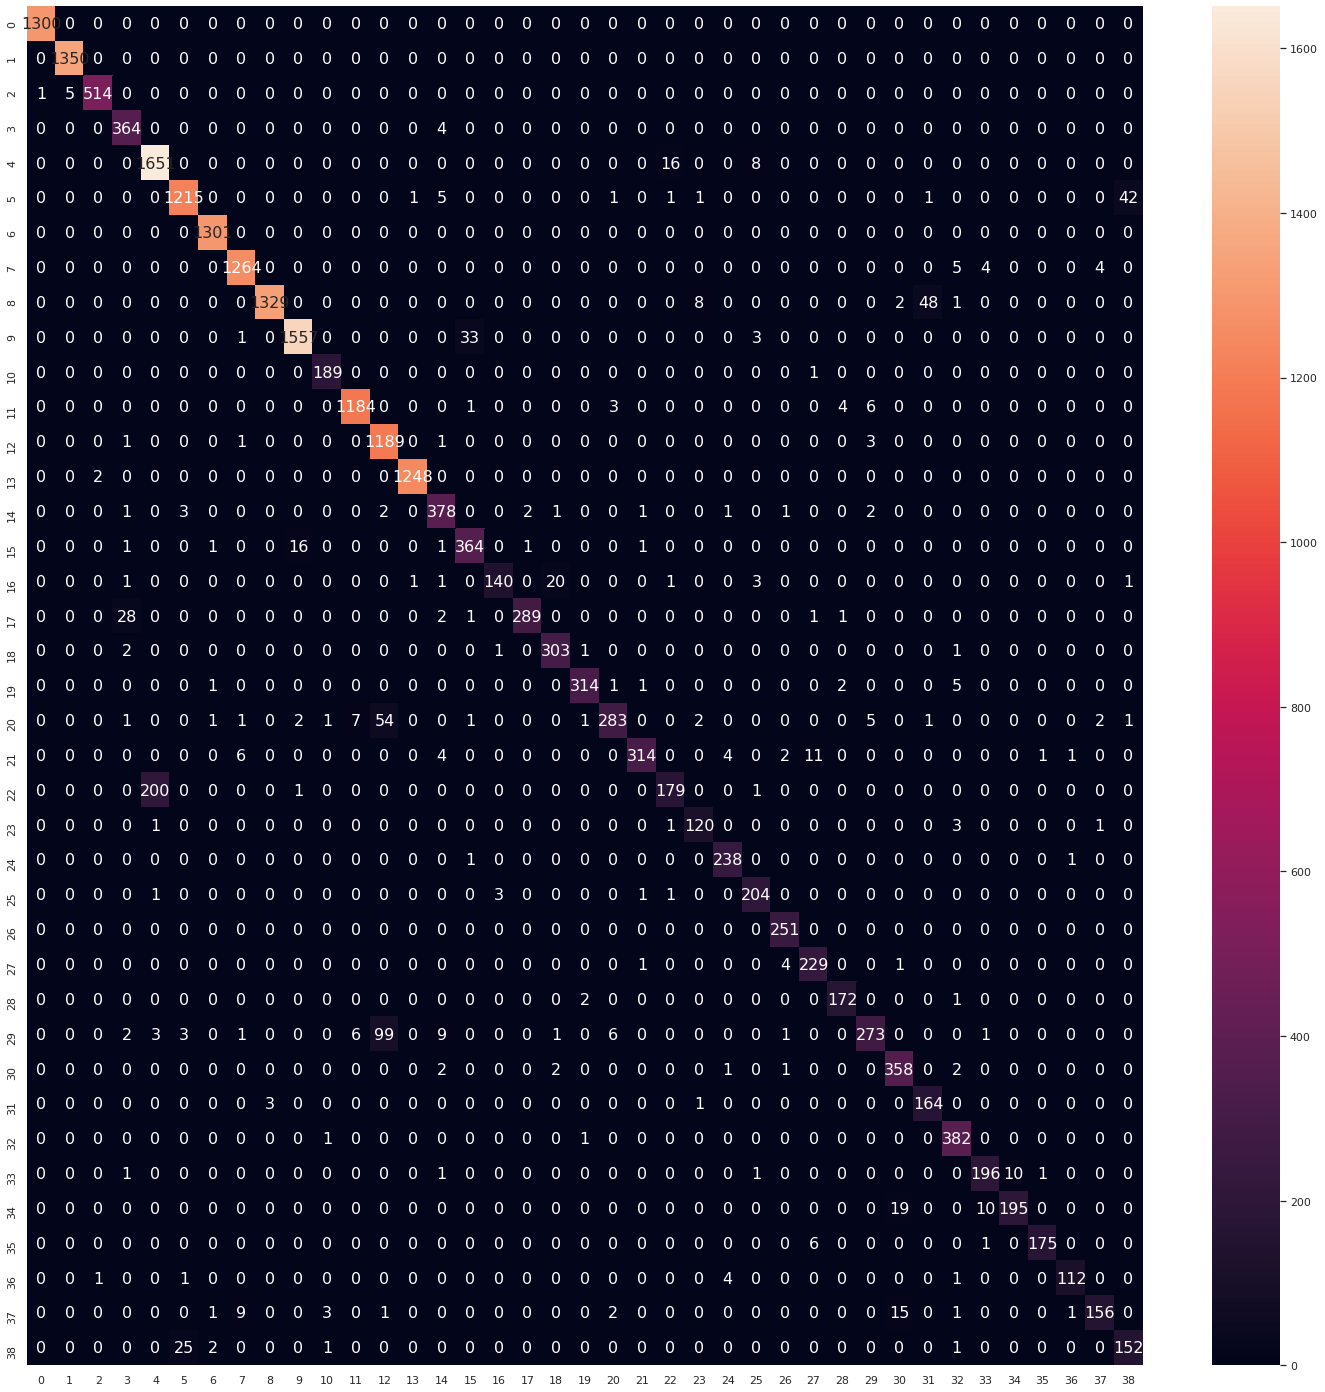

<Figure size 2160x2160 with 0 Axes>

,Precision,Recall,F1_score
0,0.999231,1.000000,0.999616
1,0.996310,1.000000,0.998152
2,0.994197,0.988462,0.991321
3,0.905473,0.989130,0.945455
4,0.889547,0.985672,0.935146
5,0.974338,0.958958,0.966587
6,0.995409,1.000000,0.997699
7,0.985191,0.989820,0.987500
8,0.997748,0.957493,0.977206
9,0.987944,0.976788,0.982334


In [13]:
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.math import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities.argmax(axis=1)

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(39), range(39))
sn.set(font_scale=1.4) # for label size
sn.set(rc={'figure.figsize':(25,25)})
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt= 'd') # font size
plt.figure(figsize = (30,30))
plt.show()

precision, recall, f1, _ = score(y_true, y_pred)
pd.DataFrame([precision, recall, f1] , index = ['Precision', 'Recall', 'F1_score']).T


In [15]:
mat.diagonal().sum()/mat.sum()

0.9587995027526194

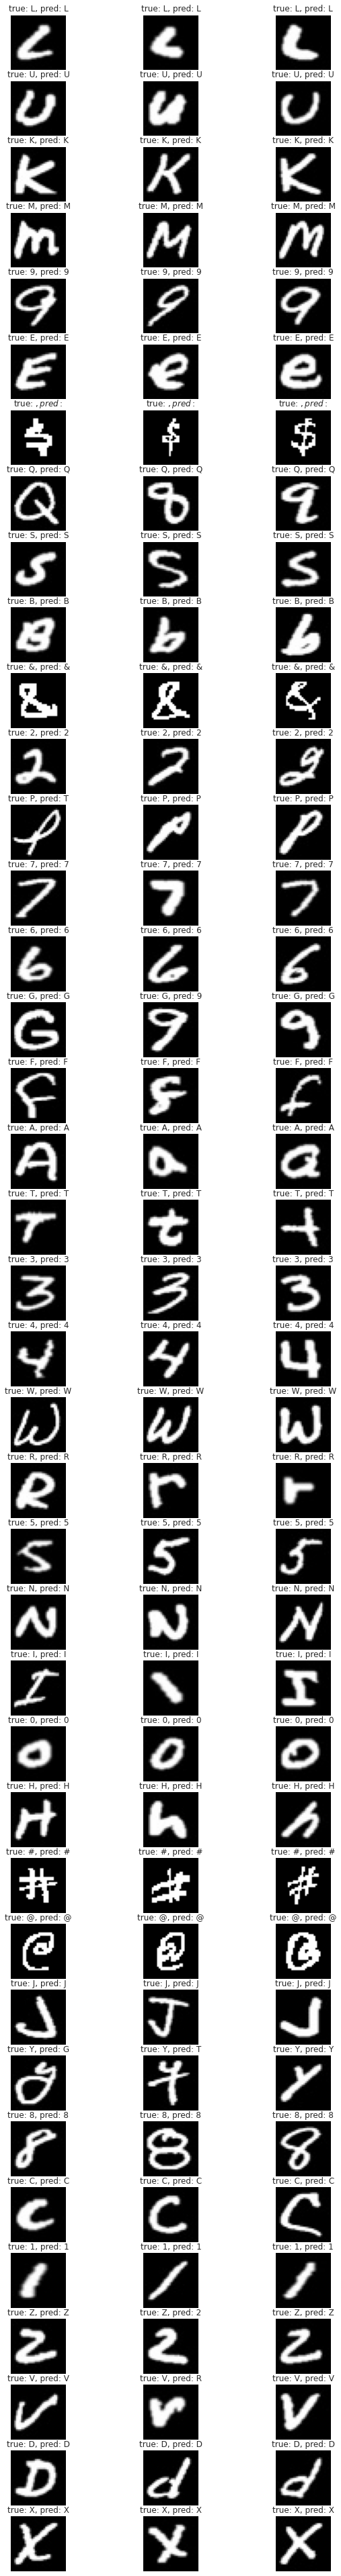

In [16]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

classes = os.listdir('/content/hand_written/Validation')
idx_class = {str(idx):classes for classes,idx in test_generator.class_indices.items()}
i = 0
plt.figure(figsize=(10,70))
for c in classes:
  imgs = os.listdir('/content/hand_written/Validation/'+c)
  num_files = 0
  for img in imgs:
    plt.subplot(39,3,i+1)
    imga = image.img_to_array(image.load_img('/content/hand_written/Validation/' + c + '/' + img, target_size = (32,32,3)))
    imga_normalized = imga/255.
    imga_add = np.expand_dims(imga_normalized, axis=0)
    
    pred = model.predict(imga_add).argmax(axis = 1)
    plt.grid(b=None)
    plt.axis('off')
    plt.imshow(imga_add[0])
    plt.title('true: {}, pred: {}'.format(c, idx_class[str(pred[0])]))
    
    i+=1
    num_files+=1
    if num_files == 3:
      break

